In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *


### transforms for downstream tasks

In [2]:
transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_eval = transforms.Compose([
        transforms.RandomResizedCrop((32,32), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [3]:
dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform= transform_eval)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


### Data preporcessing for how much percentage of the data is used for finetune

In [4]:
with open('evalset.txt', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['current_class','label'])

def create_evalset(ds):
  
  airplane_i, dog_i, deer_i, frog_i, cat_i, bird_i, horse_i, automobile_i, ship_i, truck_i = [], [], [], [], [],[],[],[],[],[]
  dog_idx, deer_idx, airplane_idx, frog_idx, cat_idx, bird_idx, automobile_idx, ship_idx, truck_idx, horse_idx = ds.class_to_idx['dog'], ds.class_to_idx['deer'],ds.class_to_idx['airplane'],ds.class_to_idx['frog'],ds.class_to_idx['cat'],ds.class_to_idx['bird'],ds.class_to_idx['automobile'],ds.class_to_idx['ship'],ds.class_to_idx['truck'],ds.class_to_idx['horse']
  label=[]
  for i in range(len(ds)):
    current_class = ds[i][1]
    if current_class == dog_idx:
      dog_i.append(i)
      label='dog'
    elif current_class == deer_idx:
      deer_i.append(i)
      label='deer'
    elif current_class == airplane_idx:
      airplane_i.append(i)
      label='airplane'
    elif current_class == frog_idx:
      frog_i.append(i)
      label='frog'
    elif current_class == cat_idx:
      cat_i.append(i)
      label='cat'
    elif current_class == bird_idx:
      bird_i.append(i)
      label='bird'
    elif current_class == automobile_idx:
      automobile_i.append(i)
      label='automobile'
    elif current_class == ship_idx:
      ship_i.append(i)
      label='ship'
    elif current_class == truck_idx:
      truck_i.append(i) 
      label='truck'
    else:
      horse_i.append(i)
      label='horse'
    with open('evalset.txt', 'a', newline='') as csvfile:
          writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
          writer.writerow([current_class, label])
# For 1% labelled data
  # airplane_ei = airplane_i[int(0.999 * len(airplane_i)):]
  # dog_ei = dog_i[int(0.999 * len(dog_i)):]
  # deer_ei = deer_i[int(0.999 * len(deer_i)):]
  # frog_ei = frog_i[int(0.999 * len(frog_i)):]
  # cat_ei = cat_i[int(0.999 * len(cat_i)):]
  # bird_ei = bird_i[int(0.999 * len(bird_i)):]
  # horse_ei = horse_i[int(0.999 * len(horse_i)):]
  # automobile_ei = automobile_i[int(0.999 * len(automobile_i)):]
  # ship_ei = ship_i[int(0.999 * len(ship_i)):]
  # truck_ei = truck_i[int(0.999 * len(truck_i)):]

# # For 10% labelled data
  airplane_ei = airplane_i[int(0.98 * len(airplane_i)):]
  dog_ei = dog_i[int(0.98 * len(dog_i)):]
  deer_ei = deer_i[int(0.98 * len(deer_i)):]
  frog_ei = frog_i[int(0.98 * len(frog_i)):]
  cat_ei = cat_i[int(0.98 * len(cat_i)):]
  bird_ei = bird_i[int(0.98 * len(bird_i)):]
  horse_ei = horse_i[int(0.98 * len(horse_i)):]
  automobile_ei = automobile_i[int(0.98 * len(automobile_i)):]
  ship_ei = ship_i[int(0.98 * len(ship_i)):]
  truck_ei = truck_i[int(0.98 * len(truck_i)):]


# # For 30% labelled data
  # airplane_ei = airplane_i[int(0.94 * len(airplane_i)):]
  # dog_ei = dog_i[int(0.94 * len(dog_i)):]
  # deer_ei = deer_i[int(0.94 * len(deer_i)):]
  # frog_ei = frog_i[int(0.94 * len(frog_i)):]
  # cat_ei = cat_i[int(0.94 * len(cat_i)):]
  # bird_ei = bird_i[int(0.94 * len(bird_i)):]
  # horse_ei = horse_i[int(0.94 * len(horse_i)):]
  # automobile_ei = automobile_i[int(0.94 * len(automobile_i)):]
  # ship_ei = ship_i[int(0.94 * len(ship_i)):]
  # truck_ei = truck_i[int(0.94 * len(truck_i)):]

# # For 50% labelled data
  # airplane_ei = airplane_i[int(0.9 * len(airplane_i)):]
  # dog_ei = dog_i[int(0.9 * len(dog_i)):]
  # deer_ei = deer_i[int(0.9 * len(deer_i)):]
  # frog_ei = frog_i[int(0.9 * len(frog_i)):]
  # cat_ei = cat_i[int(0.9 * len(cat_i)):]
  # bird_ei = bird_i[int(0.9 * len(bird_i)):]
  # horse_ei = horse_i[int(0.9 * len(horse_i)):]
  # automobile_ei = automobile_i[int(0.9 * len(automobile_i)):]
  # ship_ei = ship_i[int(0.9 * len(ship_i)):]
  # truck_ei = truck_i[int(0.9 * len(truck_i)):]

  evalset_l = Subset(ds, airplane_ei+ dog_ei+ deer_ei+ frog_ei+ cat_ei+ bird_ei+ horse_ei+ automobile_ei+ ship_ei+ truck_ei)

  
  return evalset_l
evalset_l = create_evalset(dataset)

In [5]:
len(evalset_l)

1000

In [6]:
evalloader = torch.utils.data.DataLoader(
    evalset_l, batch_size=32, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=True, num_workers=0)


In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [8]:
class SimCLR_model(nn.Module):
    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.linear=nn.Linear(n_features, n_features)

        self.base_encoder.fc = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
base_encoder = ResNet50()
projection_dim=128
n_features= base_encoder.linear.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)

net= net.to(device)
#net

In [11]:

base_encoder.linear.weight #weights of the linear layer before loading the model 

Parameter containing:
tensor([[ 0.0026,  0.0082, -0.0152,  ..., -0.0019,  0.0067,  0.0181],
        [-0.0111,  0.0094, -0.0046,  ..., -0.0130, -0.0149,  0.0011],
        [ 0.0095,  0.0194,  0.0189,  ...,  0.0130, -0.0170,  0.0077],
        ...,
        [ 0.0185, -0.0086, -0.0151,  ..., -0.0065, -0.0159, -0.0018],
        [ 0.0115, -0.0217, -0.0166,  ..., -0.0153,  0.0207, -0.0071],
        [-0.0007, -0.0160,  0.0202,  ..., -0.0213,  0.0146,  0.0128]],
       device='cuda:0', requires_grad=True)

In [12]:

path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r.pt"
checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
loss= checkpoint['loss']
epoch = checkpoint['epoch']

start_epoch=0
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [13]:
epoch

275

In [14]:
net_eval= base_encoder
n_features= base_encoder.linear.in_features
print(n_features)
# for param in net_eval.parameters():
#     param.requires_grad = False
net_eval.fc=nn.Linear(n_features, len(classes)) 
print(net_eval.fc)
net_eval.to(device)

2048
Linear(in_features=2048, out_features=10, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [15]:
start_epoch=0
batch_size = 32
lr = 0.0001
device='cuda'
optimizer= torch.optim.SGD(net_eval.parameters(), lr, momentum=0.9, weight_decay = 0, nesterov=True)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# net_eval.to(device)

### weights of the linear layer after loading the model 

In [16]:
net_eval.linear.weight

Parameter containing:
tensor([[-0.0236, -0.0104, -0.0032,  ...,  0.0192, -0.0226, -0.0003],
        [ 0.0091,  0.0080, -0.0153,  ...,  0.0114,  0.0154,  0.0136],
        [ 0.0145, -0.0097,  0.0217,  ..., -0.0032, -0.0193,  0.0088],
        ...,
        [ 0.0048,  0.0208,  0.0206,  ...,  0.0217, -0.0140,  0.0100],
        [ 0.0082,  0.0063, -0.0216,  ..., -0.0109,  0.0198, -0.0015],
        [-0.0074,  0.0087, -0.0040,  ..., -0.0085,  0.0212, -0.0075]],
       device='cuda:0', requires_grad=True)

In [17]:
from sklearn.metrics import f1_score, classification_report


### fine-tune the downstram model  and predict on test data

In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net_eval.to(device)
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net_eval.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(evalloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_eval(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f'{epoch} Loss: {train_loss:.4f} Acc: {correct/total:.4f}')

best_acc=0

accuracies=[]

def test(epoch):
    global best_acc
    net_eval.eval()
    test_loss = 0
    correct = 0
    total = 0
    acc = 0
    
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_eval(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    acc = 100. * correct / total
    print(f'{epoch} Test Loss: {test_loss / (batch_idx + 1):.4f} Test Acc: {correct / total:.4f}')
    print(f'Test Accuracy: {acc:.2f}%')
    accuracies.append(acc)


    f1_scores = f1_score(all_targets, all_preds, average=None)
    print("F1 Scores for each class:")
    for i, f1 in enumerate(f1_scores):
        print(f'Class {i}: {f1:.4f}')

    # You can also print a detailed classification report
    # print("\nClassification Report:")
    # print(classification_report(all_targets, all_preds, target_names=classes))
        # Plot accuracy curve
   

    if acc > best_acc:
        parameters_finetune = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'loss': test_loss
        }
        best_acc = acc

 
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)

    # if epoch %25==0:
    #   parameters_end = {
    #         'net': net_eval.state_dict(),
    #         'acc': acc,
    #         'epoch': epoch,
    #         'loss': test_loss
    #   }
      # paramsend_save_name = 'paramsend_finetune.pt'
      # path_paramsend = F"/content/gdrive/MyDrive/{paramsend_save_name}" 
      # torch.save(parameters_end, path_paramsend)


Epoch: 0


0 Loss: 201.9871 Acc: 0.0630
0 Test Loss: 9.6168 Test Acc: 0.2283
Test Accuracy: 22.83%
F1 Scores for each class:
Class 0: 0.0000
Class 1: 0.2997
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.2273
Class 5: 0.1981
Class 6: 0.0507
Class 7: 0.3342
Class 8: 0.3869
Class 9: 0.0589

Epoch: 1
1 Loss: 73.5794 Acc: 0.3700
1 Test Loss: 4.7218 Test Acc: 0.5030
Test Accuracy: 50.30%
F1 Scores for each class:
Class 0: 0.4068
Class 1: 0.7294
Class 2: 0.3036
Class 3: 0.2379
Class 4: 0.4302
Class 5: 0.4945
Class 6: 0.6296
Class 7: 0.4380
Class 8: 0.5902
Class 9: 0.6891

Epoch: 2
2 Loss: 51.8000 Acc: 0.5250
2 Test Loss: 6.3218 Test Acc: 0.5779
Test Accuracy: 57.79%
F1 Scores for each class:
Class 0: 0.4656
Class 1: 0.8044
Class 2: 0.3158
Class 3: 0.3639
Class 4: 0.4631
Class 5: 0.5611
Class 6: 0.6533
Class 7: 0.6027
Class 8: 0.7065
Class 9: 0.7552

Epoch: 3
3 Loss: 46.7560 Acc: 0.5520
3 Test Loss: 7.0525 Test Acc: 0.5898
Test Accuracy: 58.98%
F1 Scores for each class:
Class 0: 0.5113
Class 1: 0.8196
Class

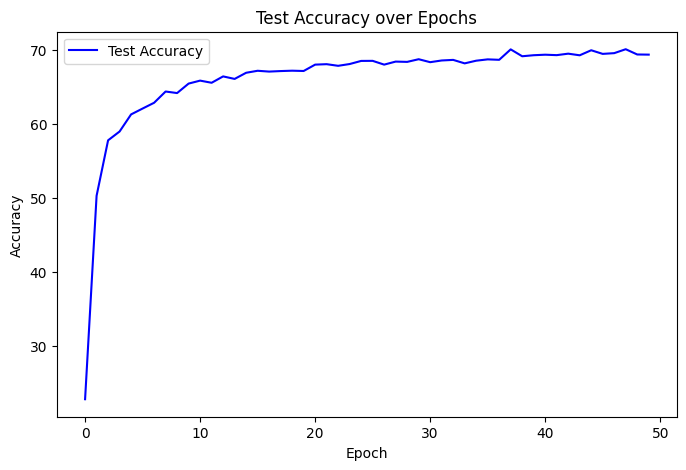

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()   

In [20]:
np.savetxt('/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/test_accuracies_50%.txt', accuracies)


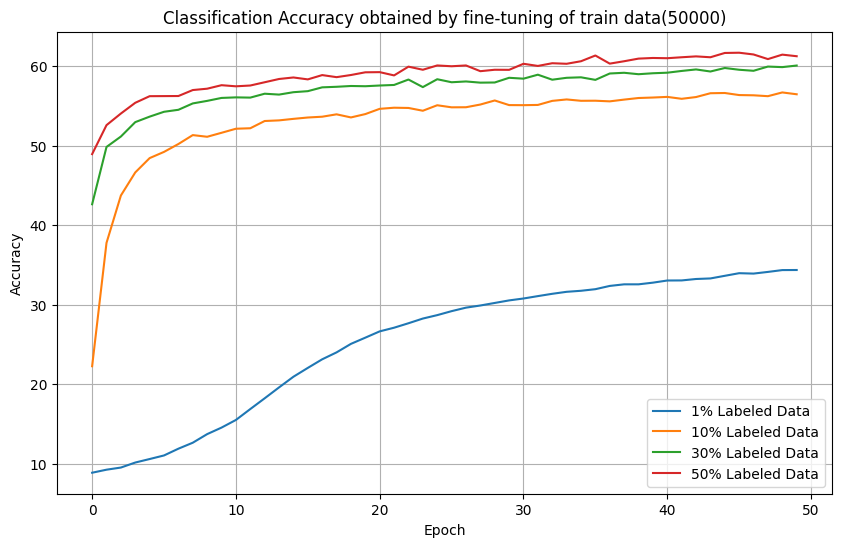

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Load accuracy data from text files
file_paths = [
    '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/save_data_simclr/1% label.txt',
    '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/save_data_simclr/10%label.txt',
    '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/save_data_simclr/30%label.txt',
    '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/save_data_simclr/50%label.txt'
]

# Initialize an empty list to store accuracy arrays
accuracy_arrays = []

# Load data from each file
for file_path in file_paths:
    accuracy_data = np.loadtxt(file_path)
    accuracy_arrays.append(accuracy_data)

# Plot the accuracy curves in one figure
plt.figure(figsize=(10, 6))

for percentage, accuracy_data in zip([1, 10, 30, 50], accuracy_arrays):
    plt.plot(accuracy_data, label=f'{percentage}% Labeled Data')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy obtained by fine-tuning of train data(50000)')
plt.grid(True)
plt.legend()
plt.show()
